![cabinetry logo](_static/cabinetry_logo_small.png)

To run this notebook outside of the provided Binder environment, you need `cabinetry`. You can install it with `pip` by uncommenting the cell below. The `[contrib]` setup extra installs libraries that are not needed for the core `cabinetry` logic, but for `ROOT` file handling and plotting. We will also install the `JAX` backend for `pyhf` here for a demonstration below, as well as `hist` (again, not needed if running via Binder).

In [1]:
#! pip install cabinetry[contrib]
#! pip install pyhf[jax,contrib]
#! pip install hist

`cabinetry` outputs text with the Python `logging` module. We use a helper function to set some sensible defaults, but you are welcome to customize this to your own needs.

In [2]:
import cabinetry
cabinetry.set_logging()

We will have a look at three different ways of using `cabinetry` in this notebook:
- creating a statistical model,
- performing statistical inference with our model,
- exploring the statistical model of an ATLAS analysis

There is also bonus material at the end for you to look through.

<br>

# Creating a statistical model
Statistical models are constructed following instructions in a configuration. You can specify your model in a configuration in `YAML` or `JSON` format, or alternatively as a Python dictionary. Here we will go the dictionary route. Have a look at the `config_example.yml` file for a `YAML` example.

<br>

### Defining the model

There are a few things we need. First up, some general settings:

In [3]:
config = {
   "General":{
      "Measurement": "PyHEP_cabinetry",   # name for our example
      "POI": "Signal_norm",               # parameter of interest - what we want to measure 
      "InputPath": "input/{SamplePaths}", # where to find input data
      "HistogramFolder": "histograms/"    # where to store histograms

   }
}

Note the `input/{SamplePaths}` structure, which we will get back to shortly.

Now it is time to think more about physics, let's define a phase space region that contains data we want to fit to.

In [4]:
config.update({
   "Regions":[
      {
         "Name": "Signal_region", 
         "Variable": "jet_pt",                 # which variable we bin histograms in
         "Filter": "lep_charge > 0",           # event selection
         "Binning": [200, 300, 400, 500, 600]
      }
   ]
})

`"Regions"` is a list, because we can use events from more than one phase space region.

We also need to specify where our observed data is stored. Considerations about physics become important now: which types of processes do we expect to show up in this phase space region? We list them below, those samples are typically simulated with Monte Carlo methods.

In [5]:
config.update({
   "Samples":[
      {
         "Name": "Data",
         "Tree": "pseudodata",
         "SamplePaths": "data.root",
         "Data": True                       # observed data is handled differently, need to distinguish
      },
      {
         "Name": "Signal",
         "Tree": "signal",
         "SamplePaths": "prediction.root",
         "Weight": "weight"                 # weights: Monte Carlo integration, simulation correction etc.
      },
      {
         "Name": "Background",
         "Tree": "background",
         "SamplePaths": "prediction.root",
         "Weight": "weight"
      }
   ]
})

`"Samples"` is again a list, allowing us to include arbitrarly many different types of processes we may need to consider.

We are almost done defining our statistical model. What about systematic uncertainties? For now, we won't define any.

In [6]:
config.update({"Systematics": []})

<br>
There is one more thing we need though: we said our POI (parameter of interest) was `"Signal_norm"`. That is a normalization factor, describing the normalization of somthing. We still need to define what it does!

In [7]:
config.update({
   "NormFactors":[
      {
         "Name": "Signal_norm",
         "Samples": "Signal",    # we want this parameter to scale the signal
         "Nominal": 1,
         "Bounds": [-5, 10]
      }
   ]
})

<br>
It is a good idea to validate that our configuration satisfies the `cabinetry` configuration schema.

In [8]:
cabinetry.configuration.validate(config)

True

<br>
That looks good, but is not sufficient to be sure that everything is fine (some things will only show up at runtime). If we use some settings `cabinetry` does not know, or forget some it expects, we would see an error. We can also get some summary information about the configuration we defined.

In [9]:
cabinetry.configuration.print_overview(config)

INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   0 Systematic(s)


<br>

### Creating histograms

We now need to create the required histograms for our statistical model.

In [10]:
cabinetry.template_builder.create_histograms(config, method="uproot")

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data_Nominal.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal_Nominal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal_Nominal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Nominal.npz


`cabinetry` used `uproot` and `boost-histogram` to create three histograms for us: the distribution of our three samples in the one phase space region we defined. We also see a warning: there are no expected signal events in the first bin of the histogram.

A post-processing step can be run to apply optional operations like histogram smoothing. See the bonus material.

In [11]:
cabinetry.template_postprocessor.run(config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data_Nominal_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal_Nominal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal_Nominal_modified.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Nominal_modified.npz


<br>
Let's visualize the histograms we have produced.

INFO - cabinetry.visualize - visualizing histogram
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/Signal_region_prefit.pdf


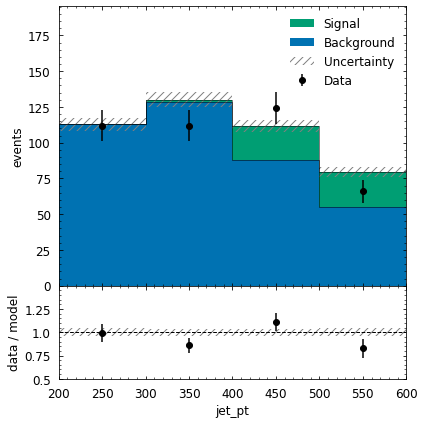

In [12]:
cabinetry.visualize.data_MC_from_histograms(config)

We see our expected distributions of signal and background, as well as our observed (pseudo-) data.

<br>

### A more complex model: adding systematic uncertainties

Let's make our model a bit more realistic and add a few systematic uncertainties:
- a 5% luminosity uncertainty,
- a `Modeling` uncertainty derived from comparing our nominal background prediction to that of a different simulator,
- a `WeightBasedModeling` modeling uncertainty derived from varying the weights we apply to background events.

In [13]:
config.update({
   "Systematics":[
      {
         "Name": "Luminosity",
         "Up": {"Normalization": 0.05},
         "Down": {"Normalization": -0.05},
         "Type": "Normalization"
      },
      {
         "Name":"Modeling",
         "Up": {"SamplePaths": "prediction.root", "Tree": "background_varied"},
         "Down": {"Symmetrize": True},
         "Samples": "Background",
         "Type": "NormPlusShape"
      },
      {
         "Name": "WeightBasedModeling",
         "Up": {"Weight": "weight_up"},
         "Down": {"Weight": "0.7*weight"},
         "Samples": "Background",
         "Type": "NormPlusShape"
      }
   ],
})

<br>
These new systematic uncertainties require new histograms, so let's build those.

In [14]:
cabinetry.template_builder.create_histograms(config, method="uproot")
cabinetry.template_postprocessor.run(config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data_Nominal.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal_Nominal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal_Nominal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Nominal.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Bac

<br>
We can visualize the template histograms corresponding to systematic variations of our model.

INFO - cabinetry.visualize - visualizing systematics templates
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/templates/Signal_region_Background_Modeling.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/templates/Signal_region_Background_WeightBasedModeling.pdf


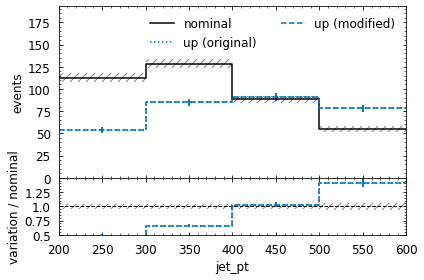

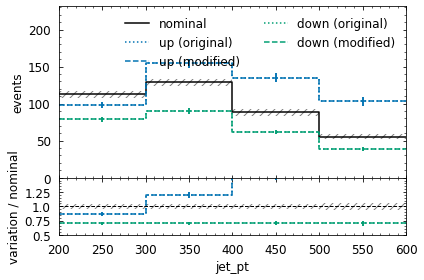

In [15]:
cabinetry.visualize.templates(config)

The top figure is our `Modeling` uncertainty, where we compare our nominal background prediction to that of another simulator, here called the "up" variation. At the bottom are the weight-based variations: you can see the "down" variation, defined by multiplying the nominal weight by `0.7`, is a factor `0.7` smaller than nominal.

<br>

### Building a workspace

With all relevant histograms available, we can now construct a `pyhf` workspace. This is our serialized fit model. It contains everything needed to construct a likelihood function via `pyhf`, which is then used for inference.

In [16]:
workspace_path = "PyHEP_workspace.json"
ws = cabinetry.workspace.build(config)
cabinetry.workspace.save(ws, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Background in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys Modeling to sample Background in region Signal_region
DEBUG - cabinetry.workspace - normalization impact of systematic Modeling on sample Background in region Signal_region is 0.800
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys WeightBasedModeling to sample Background in region Signal_region
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to workspaces/PyHEP_workspace.json


Saving is optional, we could directly continue with the `ws` object. `pyhf` has validated our workspace, and we are now ready for statistical inference.

<br>

# Performing statistical inference with our model

To perform inference, we need two things: a probability density function (pdf), or *model*, and data to fit it to. Both are contained in the workspace.

In [17]:
model, data = cabinetry.model_utils.model_and_data(ws)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)


You can see our `Signal_norm` normalization showing up, in addition to parameters for the systematic uncertainties we defined.

There is also `staterror_Signal_region`: these are parameters automatically created by `cabinetry` to encode systematic uncertainty due to the finite sample size of our predicted distributions for signal and background.

`data` is a list, starting with the observed counts per bin.

In [18]:
data

[112.0, 112.0, 124.0, 66.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]

What comes after is so-called auxiliary data. Check out [this `pyhf` tutorial](https://pyhf.github.io/pyhf-tutorial/HelloWorld.html#auxiliary-data) to learn more about this important concept. You can view it as data observed in previous measurements, which inform our current model. In this case the auxiliary data is associated to the `staterror_Signal_region` parameter. 

<br>

### Maximum likelihood estimate (MLE)

Let's fit our model to data to obtain the maximum likelihood estimate (MLE).

In [19]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 310              │
│ EDM = 2.82e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 17.194232 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinet

<br>
The fit converged, and we see the best-fit parameter results reported. The results are stored in a named tuple. This allows for easy access of the results.

In [20]:
for label, result, unc in zip(fit_results.labels, fit_results.bestfit, fit_results.uncertainty):
    print(f"{label}: {result:.3f} +/- {unc:.3f}")

staterror_Signal_region[bin_0]: 1.001 +/- 0.041
staterror_Signal_region[bin_1]: 0.989 +/- 0.038
staterror_Signal_region[bin_2]: 1.020 +/- 0.037
staterror_Signal_region[bin_3]: 0.983 +/- 0.043
Signal_norm: 1.693 +/- 0.946
Luminosity: -0.090 +/- 0.991
Modeling: -0.326 +/- 0.555
WeightBasedModeling: -0.587 +/- 0.627


<br>
It is usually helpful to visualize the fit results. Let's start with the *pull plot* showing us best-fit parameter results.

DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/pulls.pdf


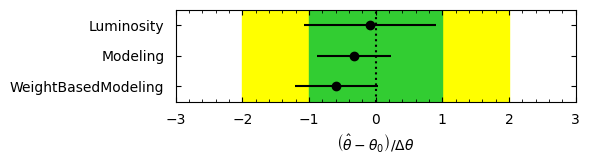

In [21]:
cabinetry.visualize.pulls(fit_results, exclude="Signal_norm")

<br>
The parameter correlation matrix has a handy `pruning_threshold` setting to filter out parameters that are not highly correlated with others.

DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/correlation_matrix.pdf


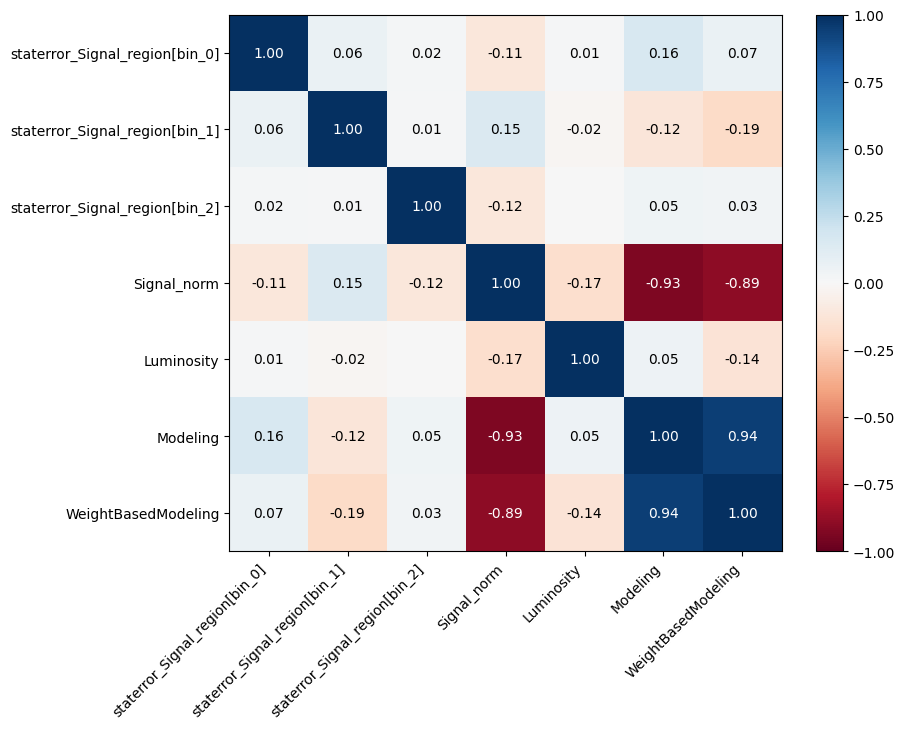

In [22]:
cabinetry.visualize.correlation_matrix(fit_results, pruning_threshold=0.1)

<br>
How does the model look like after fit to data? Let's first look again at the model before the fit to data. We use information from the workspace for plotting, and from the config for cosmetics (axis label / binning).

DEBUG - cabinetry.model_utils - total stdev is [[69, 58.3, 38.2, 45.3]]
DEBUG - cabinetry.model_utils - total stdev per channel is [137]
INFO - cabinetry.visualize - generating pre-fit yield table
INFO - cabinetry.tabulate - yields per bin:
╒════════════╤═════════════════╤════════════════╤════════════════╤═══════════════╕
│ sample     │ Signal_region   │                │                │               │
│            │ bin 1           │ bin 2          │ bin 3          │ bin 4         │
╞════════════╪═════════════════╪════════════════╪════════════════╪═══════════════╡
│ Background │ 112.74          │ 128.62         │ 88.11          │ 55.25         │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ Signal     │ 0.00            │ 1.59           │ 23.62          │ 24.55         │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ total      │ 112.74 ± 69.04  │ 130.21 ± 58.34 │ 111.72 ± 38.22 │ 79.79 ± 45.30 │
├───────────

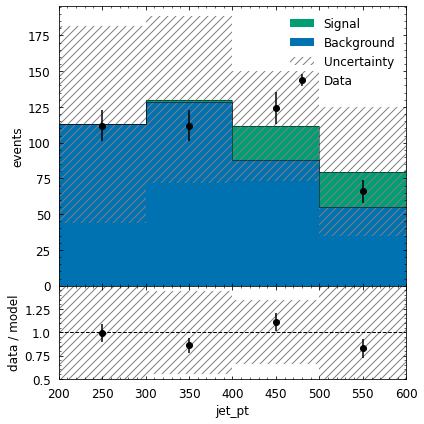

In [23]:
cabinetry.visualize.data_MC(model, data, config=config)

<br>
This gave us not only a plot, but also yield tables with model prediction and uncertainties. We create the post-fit version of this plot by passing in `fit_results`, and this time we skip the table to fit both figures onto the same screen.

DEBUG - cabinetry.model_utils - total stdev is [[11.9, 7.28, 7.47, 7.67]]
DEBUG - cabinetry.model_utils - total stdev per channel is [20.5]
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/Signal_region_postfit.pdf


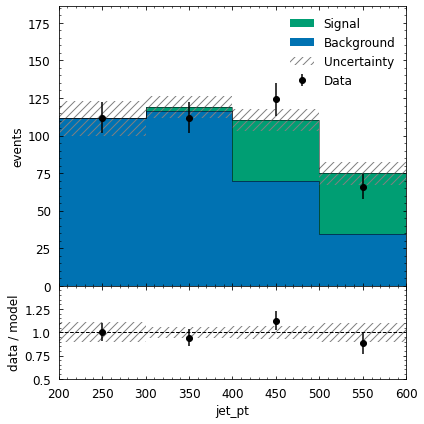

In [24]:
cabinetry.visualize.data_MC(model, data, config=config, fit_results=fit_results, include_table=False)

The model uncertainties have increased since they now include the signal normalization uncertainty we determined in the fit (not defined pre-fit). The contribution of signal in green has also increased.

<br>

### Expected sensitivity with the Asimov dataset

We can evaluate the expected performance of our model with so-called (see [arXiv:1007.1727](https://arxiv.org/abs/1007.1727)).

In [25]:
asimov_data = cabinetry.model_utils.build_Asimov_data(model)
_ = cabinetry.fit.fit(model, asimov_data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 13.3                       │              Nfcn = 202              │
│ EDM = 4.51e-14 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 13.296992 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinet

By definition, none of the parameters are pulled away from their initial values in this fit.

<br>

### Beyond MLEs: discovery significance and parameter limits

Now that we ran a basic fit, let's do something slightly more involved: calculate discovery significance.

In [26]:
significance_results = cabinetry.fit.significance(model, data)

INFO - cabinetry.fit - calculating discovery significance
INFO - cabinetry.fit - observed p-value: 3.58372088%
INFO - cabinetry.fit - observed significance: 1.801
INFO - cabinetry.fit - expected p-value: 14.77483709%
INFO - cabinetry.fit - expected significance: 1.046


The results are again packaged up in a named tuple. The observed significance is higher than the expected significance, consistent with fitting a `Signal_norm` value above one.

We can also calculate expected and observed 95% confidence level upper parameter limits with the [CLs method](https://doi.org/10.1088%2F0954-3899%2F28%2F10%2F313). The implementation uses Brent bracketing to find `CLs=0.05` crossings.

INFO - cabinetry.fit - calculating upper limit for Signal_norm
DEBUG - cabinetry.fit - setting lower parameter bound for POI to 0
INFO - cabinetry.fit - determining observed upper limit
DEBUG - cabinetry.fit - Signal_norm = 0.1000, observed CLs = 0.9176
DEBUG - cabinetry.fit - Signal_norm = 10.0000, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 9.4606, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 4.7803, observed CLs = 0.0001
DEBUG - cabinetry.fit - Signal_norm = 2.4401, observed CLs = 0.2174
DEBUG - cabinetry.fit - Signal_norm = 4.2427, observed CLs = 0.0012
DEBUG - cabinetry.fit - Signal_norm = 3.3414, observed CLs = 0.0302
DEBUG - cabinetry.fit - Signal_norm = 2.8908, observed CLs = 0.0935
DEBUG - cabinetry.fit - Signal_norm = 3.2002, observed CLs = 0.0444
DEBUG - cabinetry.fit - Signal_norm = 3.1514, observed CLs = 0.0504
DEBUG - cabinetry.fit - Signal_norm = 3.1564, observed CLs = 0.0498
INFO - cabinetry.fit - successfully converged after 11 steps
INFO

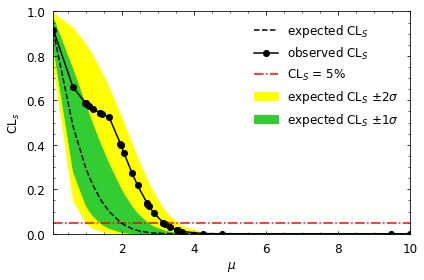

In [27]:
limit_results = cabinetry.fit.limit(model, data)
cabinetry.visualize.limit(limit_results)

Our observed limit is weaker than the expectation, consistent with us fitting a bit more signal than expected in our MLE fit.

<br>

# Exploring the statistical model of an ATLAS analysis

Let's explore the statistical model used in an ATLAS search for bottom-squark pair production: [JHEP 12 (2019) 060](https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/SUSY-2018-31/). The corresponding workspace is available on HEPData: [10.17182/hepdata.89408.v3](https://doi.org/10.17182/hepdata.89408.v3).

We can download it, pick one of the available signals with `pyhf`, and are ready to go.

In [28]:
from pyhf.contrib.utils import download

download("https://www.hepdata.net/record/resource/1267798?view=true", "electroweakinos")
!pyhf patchset apply electroweakinos/1Lbb-likelihoods-hepdata/BkgOnly.json\
electroweakinos/1Lbb-likelihoods-hepdata/patchset.json\
--name C1N2_Wh_hbb_700_400 --output-file electroweakinos.json

<br>`pyhf` has a helpful command line interface utility to summarize the workspace content.

In [29]:
!pyhf inspect electroweakinos.json | head -n 6

                                    Summary       
                              ------------------  
                                 channels  8
                                  samples  10
                               parameters  120
                                modifiers  120


<br>
Let's extract model and data with `cabinetry`.

In [30]:
ws = cabinetry.workspace.load("electroweakinos.json")
ATLAS_model, ATLAS_data = cabinetry.model_utils.model_and_data(ws)

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier staterror_WREM_cuts (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_Eff (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_Iso (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier EG_Reco (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier JVT (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier MUON_Eff_BadMuon_stat (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier MUON_Eff_BadMuon_sys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier MUON_Eff_Iso_stat (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier MUON_Eff_Iso_sys (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier MUON_Eff_stat (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier MUON_Eff_stat_lowpt (1 new nuisance parameters)
INFO - pyhf.pdf - adding mod

<br>
We are ready to take a closer look at the content. Which phase space regions are included?

DEBUG - cabinetry.model_utils - total stdev is [[2.53, 1.74, 0.638], [3.11, 3.11, 2.15], [2.54, ... [49.4], [78.3], [33.3], [13]]
DEBUG - cabinetry.model_utils - total stdev per channel is [3.66, 5.13, 2.69, 45.8, 49.4, 78.3, 33.3, 13]
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/SRHMEM_mct2_prefit.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/SRLMEM_mct2_prefit.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/SRMMEM_mct2_prefit.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/STCREM_cuts_prefit.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/TRHMEM_cuts_prefit.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/TRLMEM_cuts_prefit.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/TRMMEM_cuts_prefit.pdf
DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/WREM_cuts_p

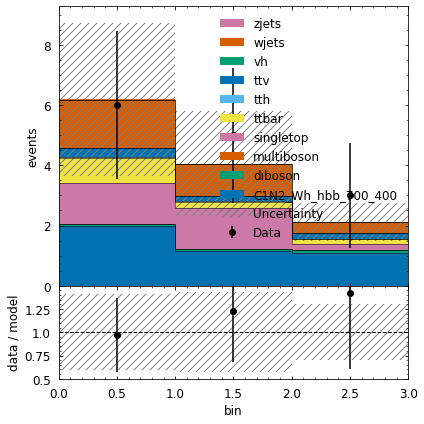

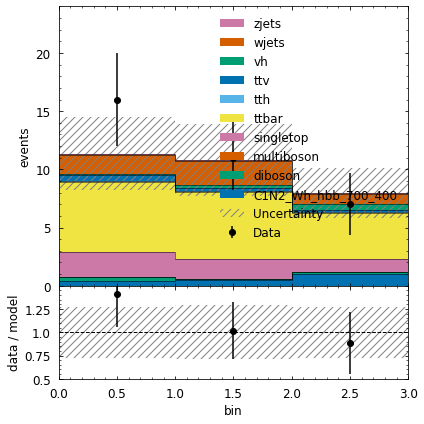

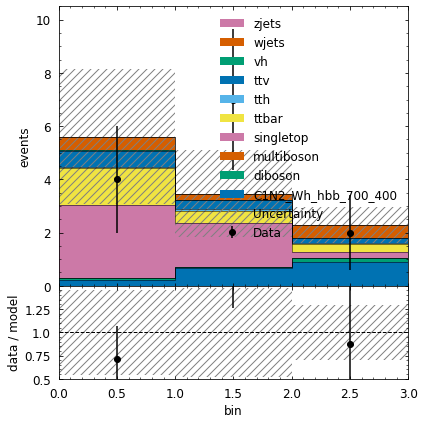

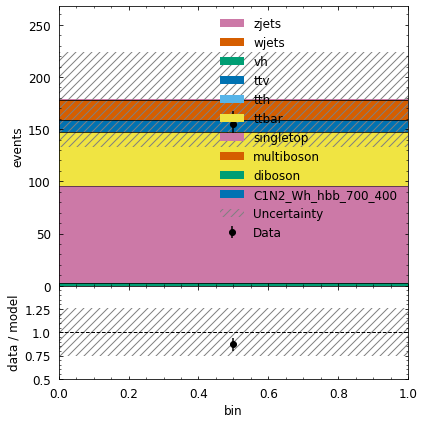

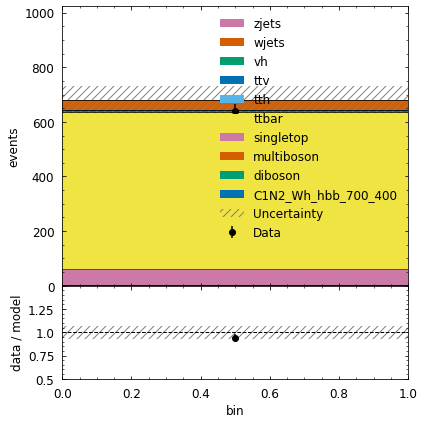

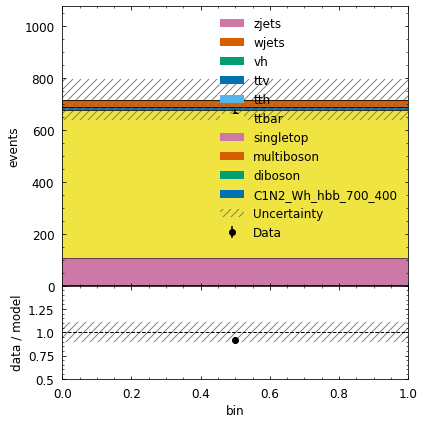

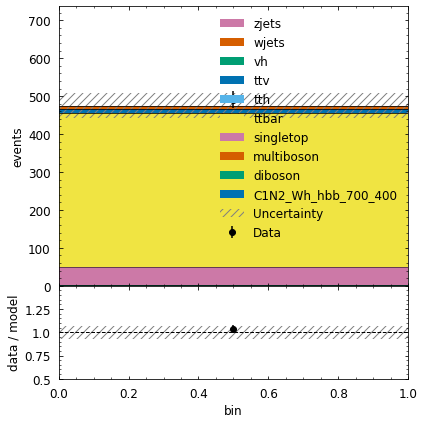

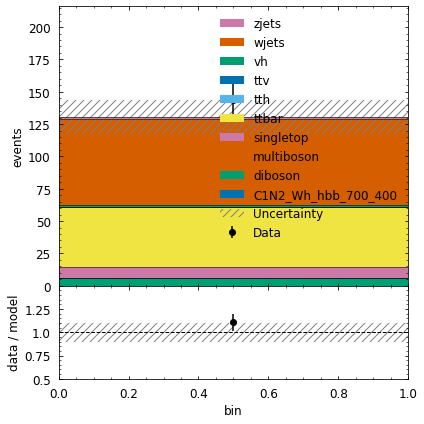

In [31]:
cabinetry.visualize.data_MC(ATLAS_model, ATLAS_data, include_table=False)

<br>
Let's fit this model to data.

In [32]:
ATLAS_fit_results = cabinetry.fit.fit(ATLAS_model, ATLAS_data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 218.4                      │             Nfcn = 22350             │
│ EDM = 5.27e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 218.408204 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabine

<br>
To parse the results more easily, let's visualize them.

DEBUG - cabinetry.contrib.matplotlib_visualize - saving figure as figures/pulls.pdf


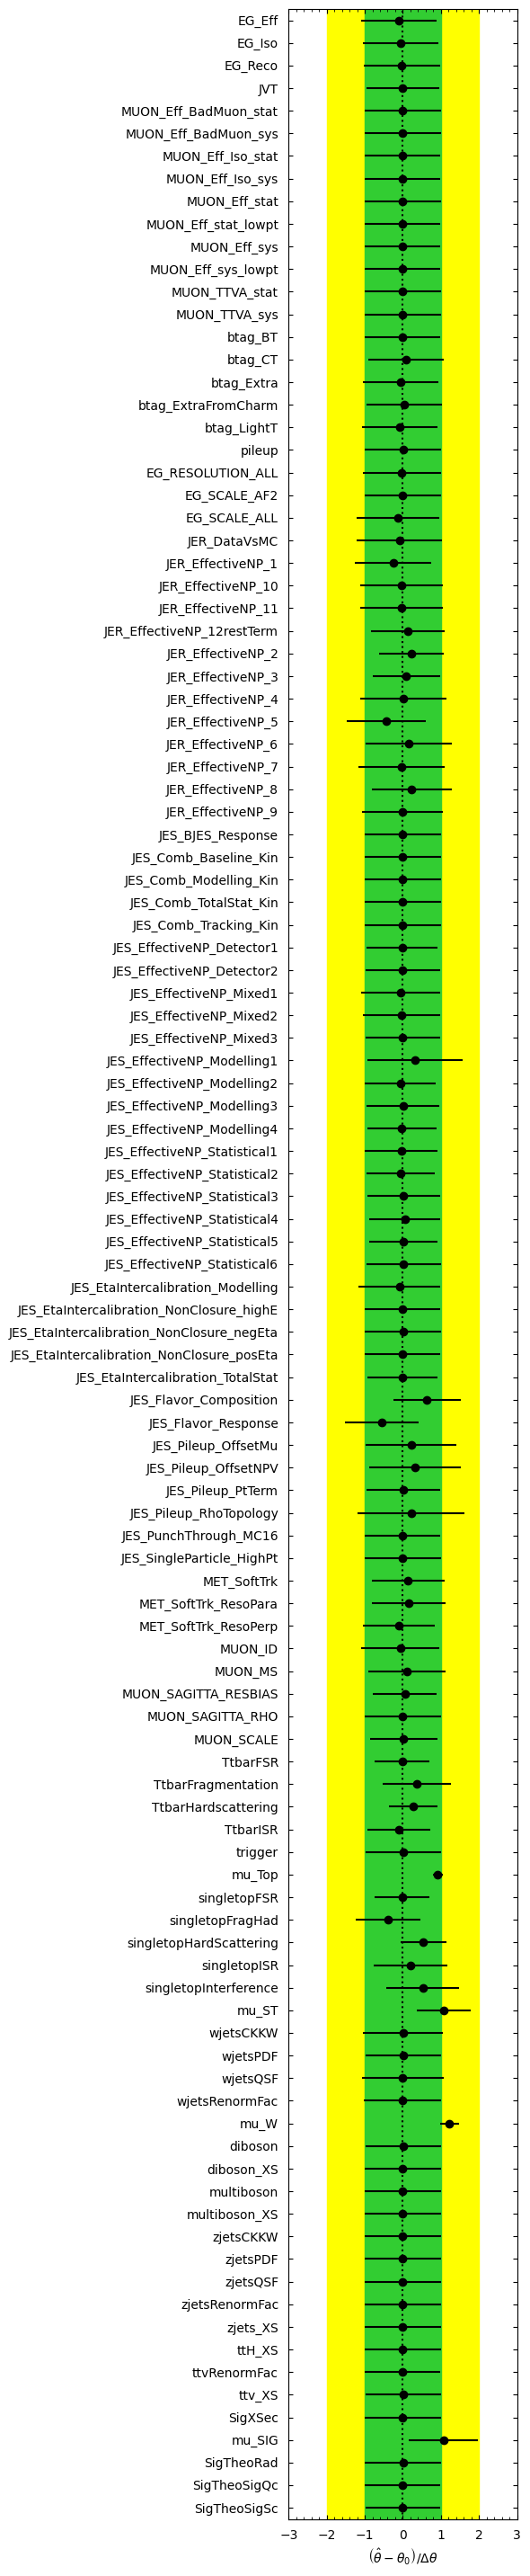

In [33]:
cabinetry.visualize.pulls(ATLAS_fit_results)

<br>
You can now also visualize the post-fit model distribution if you wish. It takes a few seconds to calculate, and is therefore commented out below.

In [34]:
#cabinetry.visualize.data_MC(ATLAS_model, ATLAS_data, fit_results=fit_results, include_table=False)

<br>

# Bonus material
Additional material to look through.

<br>

### Command line interface

`cabinetry` also provides a [command line interface](https://cabinetry.readthedocs.io/en/latest/cli.html). Feel free to explore it!

In [35]:
! cabinetry --help

Usage: cabinetry [OPTIONS] COMMAND [ARGS]...

  Entrypoint to the cabinetry CLI.

Options:
  --help  Show this message and exit.

Commands:
  templates     Produces template histograms.
  postprocess   Post-processes template histograms.
  workspace     Produces a ``pyhf`` workspace.
  fit           Fits a workspace and optionally visualizes the results.
  ranking       Ranks nuisance parameters and visualizes the result.
  scan          Performs and visualizes a likelihood scan over a parameter.
  limit         Calculates upper limits and visualizes CLs distribution.
  significance  Calculates observed and expected discovery significance.
  data-mc       Visualizes distributions of fit model and observed data.


<br>

### Histogram smoothing

This shows how to apply smoothing to a histogram after producing it. We copy our config and save the resulting histograms in a new location to not interfere with the model we have used so far.

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Data_Nominal.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal_Nominal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Signal_Nominal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Background_Nominal.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms_smoothing/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Da

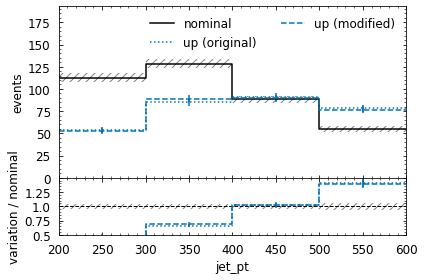

In [36]:
import copy

smoothing_config = copy.deepcopy(config)
smoothing_config["General"]["HistogramFolder"] = "histograms_smoothing/"
smoothing_config.update({
   "Systematics":[
      {
         "Name":"Modeling",
         "Up": {"SamplePaths": "prediction.root", "Tree": "background_varied"},
         "Down": {"Symmetrize": True},
         "Samples": "Background",
         "Smoothing": {"Algorithm": "353QH, twice"},  # smoothing applied
         "Type": "NormPlusShape"
      }
   ]
})
cabinetry.template_builder.create_histograms(smoothing_config, method="uproot")
cabinetry.template_postprocessor.run(smoothing_config)
cabinetry.visualize.templates(smoothing_config)

The original histogram is shown with the dotted line, and the dashed line shows the histogram after applying the [353QH, twice](https://cds.cern.ch/record/186223/) algorithm (same as `TH1::SmoothArray` in `ROOT`).

<br>

### Exploring histograms with `hist`

`cabinetry` uses `boost-histogram` internally to handle histograms. That means we can use `hist` for visualization. There are multiple ways for loading histograms, the method below uses information from the config.

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9d99afc910>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

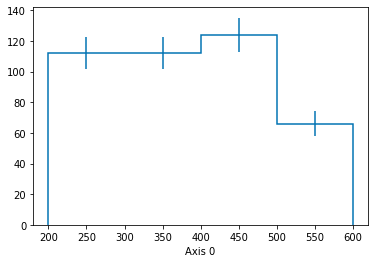

In [37]:
import hist

cabinetry_histogram = cabinetry.histo.Histogram.from_config(
    config["General"]["HistogramFolder"],
    config["Regions"][0],  # we only have one region: Signal_region
    config["Samples"][0],  # data
    {"Name": "nominal"},   # no systematics
)
hist.Hist(cabinetry_histogram).plot()

<br>

### Using a different `pyhf` backend

If your fits take a long time, or you have a GPU available and would like to make use of it, you can switch the computational backend used by `pyhf`. Set the backend via `pyhf` as you would in standalone use, and `cabinetry` will respect that choice.

In [38]:
import pyhf

pyhf.set_backend("jax")
_ = cabinetry.fit.fit(model, data)

WARNING - absl - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 121              │
│ EDM = 2.81e-05 (Goal: 0.0002)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) =

<br>

### Further MLE options: MINOS and goodness-of-fit

The `cabinetry.fit.fit` API allows use of the [MINOS algorithm](https://iminuit.readthedocs.io/en/stable/reference.html#iminuit.Minuit.minos) to compute confidence intervals via parameter scans. All parameters for which the algorithm should be run have to be listed.

In [39]:
_ = cabinetry.fit.fit(model, data, minos=["Signal_norm", "Modeling"])

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 121              │
│ EDM = 2.81e-05 (Goal: 0.0002)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
INFO - cabinetry.fit - running MINOS for Signal_norm
INFO - cabinetry.fit - running MINOS for Modeling
INFO - cabinetry.fit - MINOS results:
INFO

MINOS uncertainties are not restricted to be symmetric by construction.

`cabinetry` also implementes a goodness-of-fit calculation using the [saturated model](http://www.physics.ucla.edu/~cousins/stats/cousins_saturated.pdf).

In [40]:
_ = cabinetry.fit.fit(model, data, goodness_of_fit=True)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 121              │
│ EDM = 2.81e-05 (Goal: 0.0002)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 17.194232 at best-fit point
INFO - cabinetry.fit - fit results (with symmetric uncertainties):
INFO - cabinet

<br>

### Likelihood scan

We can perform a likelihood scan, where we hold a parameter fixed at different values and perform a MLE for the other parameters, recording the likelihood at each step in the scan.

INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 17.19                      │              Nfcn = 121              │
│ EDM = 2.81e-05 (Goal: 0.0002)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 17.194232 at best-fit point
INFO - cabinetry.fit - performing likelihood scan for Signal_norm in range (-0.192, 3.577) with 5 steps
DEBUG - cabinetry.fit - performing

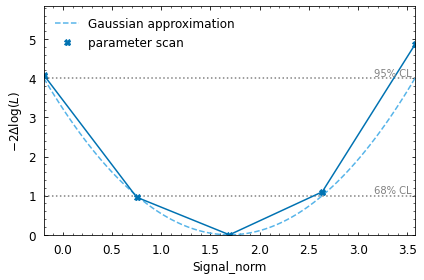

In [41]:
scan_results = cabinetry.fit.scan(model, data, "Signal_norm", n_steps=5)
cabinetry.visualize.scan(scan_results)

The scan in this example shows relatively good agreement with a naive Gaussian approximation.

<br>

### Nuisance parameter ranking

We can rank nuisance parameters (NPs) by their impact on the POI: how much does the POI change if the NP varies within its uncertainty? This requires a lot of MLE fits.

INFO - cabinetry.fit - calculating impact of staterror_Signal_region[bin_0] on Signal_norm
INFO - cabinetry.fit - MINUIT status:
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 18.24                      │              Nfcn = 107              │
│ EDM = 9.77e-06 (Goal: 0.0002)    │              Ngrad = 9               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 18.243446 at best-fit point
DEBUG - cabinetry.fit - POI is 1.581690, differ

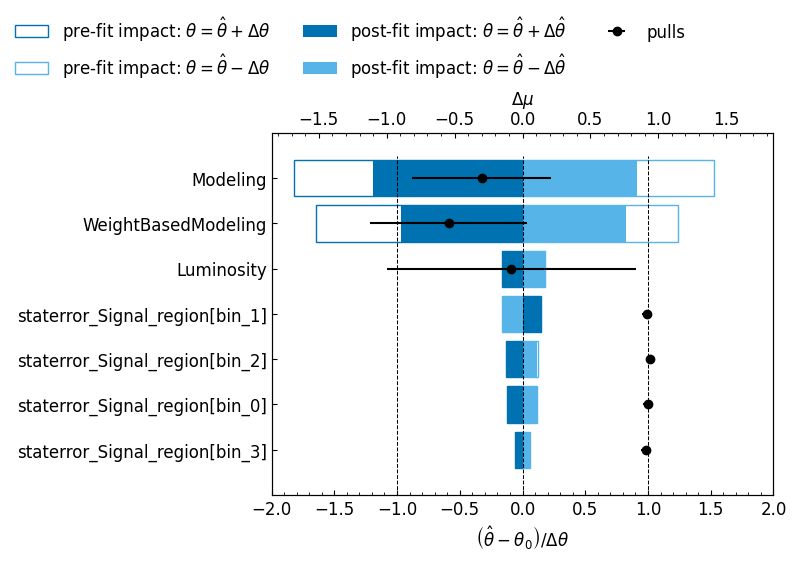

In [42]:
ranking_results = cabinetry.fit.ranking(model, data, fit_results=fit_results)
cabinetry.visualize.ranking(ranking_results)

The figure visualizes the impact of nuisance parameters on the POI in order of decreasing impact.